In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

load and display the content of two CSV files, which are typically used for building and evaluating machine learning models.

In [16]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print("Train Data:")
print(train_df.head())
print("\nTest Data:")
print(test_df.head())

Train Data:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Test Data:
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiw

Show how many instances belong to each category in the 'target' column, making it a useful visualization for understanding the class distribution in a classification problem. 

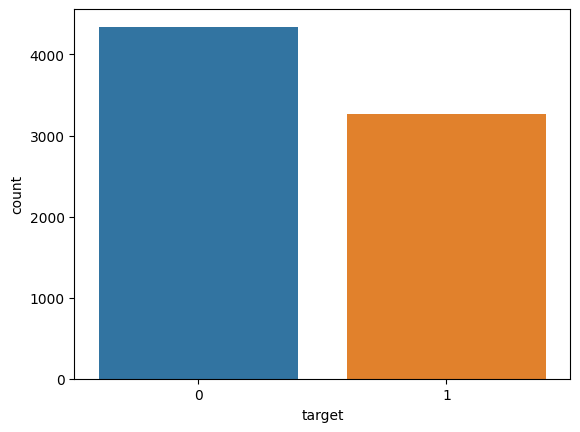

In [17]:
sns.countplot(x='target', data=train_df)
plt.show()

Perform common text preprocessing steps, such as tokenization, lowercase conversion, and stopwords removal, to prepare the text data for further natural language processing or machine learning tasks.

In [18]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(words)

train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

Trains a Word2Vec model on the tokenized and preprocessed text data from the train_df DataFrame and saves the trained model for later use in word embedding-based natural language processing tasks.

In [19]:
from gensim.utils import simple_preprocess

tokenized_text = [simple_preprocess(text) for text in train_df['processed_text']]

word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

word2vec_model.save("word2vec_model")

Calculateing word embeddings for the processed text data in both the training and test datasets using a pre-trained Word2Vec model. These word embeddings can be used as numerical representations of the text data in machine learning models for various NLP tasks.

In [20]:
def get_word_embedding(text):
    embedding = np.zeros(100)
    count = 0
    for word in text.split():
        if word in word2vec_model.wv:
            embedding += word2vec_model.wv[word]
            count += 1
    if count != 0:
        embedding /= count
    return embedding

train_df['word_embedding'] = train_df['processed_text'].apply(get_word_embedding)
test_df['word_embedding'] = test_df['processed_text'].apply(get_word_embedding)

Preparing the data by converting word embeddings and labels into NumPy arrays, splits the data into training and validation sets, and trains a logistic regression model on the training data to make predictions.

In [21]:
X = np.array(train_df['word_embedding'].to_list())
y = np.array(train_df['target'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

Evaluating the logistic regression model's performance on the validation data, including accuracy and a detailed classification report, which helps assess how well the model is performing on the task of classifying the text data.

In [22]:
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_rep)

Model Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.85      0.71       874
           1       0.57      0.27      0.37       649

    accuracy                           0.60      1523
   macro avg       0.59      0.56      0.54      1523
weighted avg       0.59      0.60      0.57      1523



Building and training a sequential neural network model for text classification using Keras.

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['processed_text'])

sequences = tokenizer.texts_to_sequences(train_df['processed_text'])
X_seq = pad_sequences(sequences, maxlen=50)  

X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(X_seq, y, test_size=0.2, random_state=42)

model_seq = Sequential()
model_seq.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=50))
model_seq.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_seq.add(Dense(1, activation='sigmoid'))

model_seq.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_seq.fit(X_train_seq, y_train_seq, epochs=5, batch_size=32, validation_data=(X_val_seq, y_val_seq))

Epoch 1/5
191/191 [==============================] - 15s 66ms/step - loss: 0.5381 - accuracy: 0.7218 - val_loss: 0.4453 - val_accuracy: 0.7984
Epoch 2/5
191/191 [==============================] - 12s 60ms/step - loss: 0.2907 - accuracy: 0.8831 - val_loss: 0.6230 - val_accuracy: 0.7249
Epoch 3/5
191/191 [==============================] - 12s 62ms/step - loss: 0.1735 - accuracy: 0.9379 - val_loss: 0.6007 - val_accuracy: 0.7623
Epoch 4/5
191/191 [==============================] - 12s 64ms/step - loss: 0.1138 - accuracy: 0.9619 - val_loss: 0.7364 - val_accuracy: 0.7426
Epoch 5/5
191/191 [==============================] - 12s 61ms/step - loss: 0.0846 - accuracy: 0.9716 - val_loss: 0.7362 - val_accuracy: 0.7518


Evaluating the performance of the previously trained sequential neural network model on a validation set and test set.

In [24]:
sequences_test = tokenizer.texts_to_sequences(test_df['processed_text'])
X_test_seq = pad_sequences(sequences_test, maxlen=50)

loss, accuracy = model_seq.evaluate(X_val_seq, y_val_seq)
print(f"Sequential Model Accuracy on Validation Set: {accuracy:.2f}")

48/48 [==============================] - 1s 11ms/step - loss: 0.7362 - accuracy: 0.7518
Sequential Model Accuracy on Validation Set: 0.75


Transforming the model's probability predictions into binary predictions (0 or 1) based on a threshold of 0.5, making it suitable for binary classification tasks.

In [25]:
test_predictions_seq = (model_seq.predict(X_test_seq) > 0.5).astype("int32")

102/102 [==============================] - 1s 12ms/step


In [26]:
submission_df_seq = pd.DataFrame({'id': test_df['id'], 'target': test_predictions_seq.flatten()})

submission_df_seq.to_csv("submission_seq.csv", index=False)

The overall purpose of this code is to demonstrate the process of preparing text data, training machine learning models (logistic regression) and deep learning models (sequential neural network), and evaluating their performance on a binary classification task. It also covers text preprocessing and word embeddings using Word2Vec, which are essential steps in many NLP applications.